# Capstone: Sentiment Analysis for Shopee
## Classification Modeling and Topic Modeling
__Grace Chia__

---

## Problem Statement

Shopee is a fast-growing e-commerce platform in Southeast Asia. In order to build an enjoyable online shopping experience, Shopee's product managers would first need to identify customer sentiment and understand users' pain points.

As such, the data science team has been tasked to classify the positive and negative reviews on Shopee Singapore's Google Play using Natural Language Processing (NLP). The model that achieves the highest accuracy and recall on the validation set will be selected for production. The team will be using topic modeling to identify the key pain points among dissatisfied customers. This will enable product managers to address their immediate needs.

## Executive Summary

The data science team web scraped 4,461 unique user reviews on Shopee's Google Play. Classical machine learning and deep learning NLP approaches were explored when building a sentiment classification model for Shopee reviews. The Voting Classifier was eventually selected as our production model as it achieved the highest accuracy and recall on the validation set. An ensemble of a TF-IDF Logistic Regression and a TF-IDF SVC, the Voting Classifier attained an accuracy of 0.904 and a recall of 0.87 on the validation data. When scored on the test set, the production model achieved 0.892 on accuracy and 0.87 on recall, outperforming the baseline accuracy of 0.61. We can thus conclude that the model generalises well on unseen data. This model serves as a good start for Shopee's product managers to classify sentiments and understand customers' pain points through Google Play reviews. The model was deployed to [Heroku](https://shopee-sentiment-analysis.herokuapp.com/).

The data science team has also identified 3 pain points among dissatisfied customers through topic modeling. These pain points include a poor payment experience, fraudulent sellers and items, and slow app performance. Addressing these pain points would not only promote an enjoyable shopping experience for customers, but would also differentiate Shopee from its competition.

Customers are most frustrated when they run into payment issues during checkout. The payment was either denied or the payment page simply took too long to load. Product managers will need to work closely with software engineers to enhance the stability and reliability of its payment gateway service. 

Several customers have dealt with fraudulent sellers on Shopee. Identifying and blocking fraudulent sellers at the early stages is the key to fraud prevention. This involves tracking a range of behavioural pattern among sellers and combing through their digital identity for any signs of suspicious behaviour. Shopee could also improve its buyers' protection scheme to regain consumers’ trust. 

Users have reported that the app hangs or crashes at the login and payment page. As such, developers will need to optimise its traffic scheduling platform's latency to accommodate high traffic during big sale events.

## Data Dictionary

An overview of the features in our dataset.

| Feature     	| Type 	| Description                                                       	|
|:-------------	|:------	|:-------------------------------------------------------------------	|
| content     	| obj  	| Raw text containing user reviews                                  	|
| content_stem 	| obj  	| Pre-processed text for modeling                                   	|
| score       	| int  	| No. of star ratings the user gave (1-5)                           	|
| target      	| int  	| Target variable <br>Postive sentiment: 0<br>Negative sentiment: 1 	|

## Model Evaluation: Summary

The table below provides an overview of the models' performance, sorted by accuracy and recall on the validation set in descending order.

|                                                             	| Accuracy on Training Set 	| Accuracy on Validation Set 	| Recall on Validation Set 	|
|:-------------------------------------------------------------	|:--------------------------:	|:----------------------------:	|:--------------------------:	|
| Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.902                    	| 0.904                      	| 0.87                     	|
| TF-IDF & SVC                                                	| 0.901                    	| 0.899                      	| 0.87                     	|
| Count Vectorizer & Naïve Bayes                              	| 0.898                    	| 0.898                      	| 0.83                     	|
| Bidirectional LSTM                                          	| 0.916                    	| 0.896                      	| 0.82                     	|
| TF-IDF & Logistic Regression                                	| 0.906                    	| 0.892                      	| 0.81                     	|
| TF-IDF & Naïve Bayes                                        	| 0.904                    	| 0.882                      	| 0.79                     	|
| Count Vectorizer & SVC                                      	| 0.900                    	| 0.872                      	| 0.75                     	|
| Count Vectorizer & Logistic Regression                      	| 0.882                    	| 0.861                      	| 0.71                     	|

|                                                                               	| Accuracy on Test Set 	| Recall on Test Set 	|
|-------------------------------------------------------------------------------	|----------------------	|--------------------	|
| Production Model: Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.892                	| 0.87               	|

## Contents:
- [Import Libraries](#Import-Libraries)
- [Load Data](#Load-Data)
- [Modeling](#Modeling)
    - [Classical Machine Learning](#Classical-Machine-Learning)
    - [Deep Learning](#Deep-Learning)
- [Model Evaluation: Summary Metrics](#Model-Evaluation:-Summary-Metrics)
- [Production Model's Most Predictive Words](#Production-Model's-Most-Predictive-Words)
- [Misclassified Reviews in Validation Set](#Misclassified-Reviews-in-Validation-Set)
- [Evaluate Production Model on Test Set](#Evaluate-Production-Model-on-Test-Set)
    - [Misclassified Reviews in Test Set](#Misclassified-Reviews-in-Test-Set)
- [Topic Modeling for Negative Sentiment](#Topic-Modeling-for-Negative-Sentiment)
    - [Pain Points and Recommendations](#Pain-Points-and-Recommendations)
- [Conclusion](#Conclusion)

## Import Libaries

In [52]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Libraries for classical machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Libraries for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Libraries for topic modeling
from pprint import pprint
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim

%matplotlib inline

## Load Data

Load in Shopee's Google Play reviews that we have collected, cleaned and pre-processed.

In [53]:
# Read the clean dataset
reviews = pd.read_csv('../data/clean_train2.csv')

In [54]:
# View the first 5 rows of our dataset
reviews.head()

,content,content_stem,score,target
0,Highly Recommended The only shopping app that ...,highli recommend shop love shop reliabl custom...,5,0
1,"In my experiences, Shopee offers better price ...",experi offer better price product reason unkno...,5,0
2,"So far so good, but the delivery can be quite ...",far good deliveri quit slow time even though l...,4,0
3,Facing really bad experience with Shopee wareh...,face realli experi warehous shown return track...,1,1
4,Edit to 3 star: Shopee finally refunded my ite...,edit star final refund return declar miss cour...,3,1


In [55]:
# 3515 documents in our dataset
reviews.shape

(3040, 4)

In [56]:
# Check the data types
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       3040 non-null   object
 1   content_stem  3040 non-null   object
 2   score         3040 non-null   int64 
 3   target        3040 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 95.1+ KB


In [57]:
# Establish our baseline score
reviews['target'].value_counts(normalize=True)

0    0.526316
1    0.473684
Name: target, dtype: float64

Given that the majority class is class 0, our **baseline score** is an accuracy of **0.61**. The baseline score will serve as a point of comparison when evaluating our models.

## Pre-Modeling

In [58]:
X = reviews['content_stem']
y = reviews['target']

In [59]:
# Perform train test split so that we can train, score and tune our models' hyperparameters 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
X_train.shape

(2432,)

In [61]:
X_val.shape

(608,)

In [62]:
y_train.value_counts(normalize=True)

0    0.526316
1    0.473684
Name: target, dtype: float64

In [63]:
y_val.value_counts(normalize=True)

0    0.526316
1    0.473684
Name: target, dtype: float64

In [64]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english') 
cvec_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
cvec_df.shape

(2432, 3483)

There are 2632 unique words in our corpus.

In [65]:
# Write a function that takes in the actual y value and model predictions, 
# and prints out the confusion matrix and classification report
# Dataset: Validation or test set

def cmat(actual_y, predictions, dataset):
    
    # Create a classification report
    print('Classification report for', dataset)
    print(classification_report(actual_y, predictions))
    print('')
    
    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
    print('Confusion matrix for', dataset)
    print(cm_df)

## Modeling

We will explore both classical machine learning and deep learning for sentiment analysis. The production model will be selected based on accuracy and recall on the validation set. 

## Classical Machine Learning

We will use the Bag of Words (BoW) representation to extract features from the text. This will be done through vectorization, specifically the CountVectorizer and TF-IDF Vectorizer. The CountVectorizer simply tokenizes and counts the word occurrences in our corpus. While on the other hand, TF-IDF tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.  

After vectorizing, we will fit a Logistic Regression, Naive Bayes and Support Vector Machine on the training data and evaluate the models' performance on the validation set.

### Count Vectorizer & Logistic Regression

In [66]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300], #100,200
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # Objects to optimise
                          param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
cvec_lr_pred = gs_cvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_lr_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV score:  0.839227889091277
Training score: 0.8667763157894737
Validation score: 0.8305921052631579

Classification report for validation set
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       320
           1       0.83      0.80      0.82       288

    accuracy                           0.83       608
   macro avg       0.83      0.83      0.83       608
weighted avg       0.83      0.83      0.83       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        274                         46
Actual Negative Review                         57                        231


### TF-IDF & Logistic Regression

In [67]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300], #100,200
    'tvec__min_df': [2,3], #2,3 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.1, 1] #.1, .01
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_lr_pred, 'validation set')

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 300, 'tvec__min_df': 2}
Best CV score:  0.8396545908385618
Training score: 0.8704769736842105
Validation score: 0.8355263157894737

Classification report for validation set
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       320
           1       0.82      0.84      0.83       288

    accuracy                           0.84       608
   macro avg       0.84      0.84      0.84       608
weighted avg       0.84      0.84      0.84       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        266                         54
Actual Negative Review                         46                        242


### Count Vectorizer & Naive Bayes

In [68]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500], #200
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Objects to optimise
                          param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_nb_pred = gs_cvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_nb_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 3}
Best CV score:  0.8400593671996223
Training score: 0.8560855263157895
Validation score: 0.8388157894736842

Classification report for validation set
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       320
           1       0.83      0.84      0.83       288

    accuracy                           0.84       608
   macro avg       0.84      0.84      0.84       608
weighted avg       0.84      0.84      0.84       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        269                         51
Actual Negative Review                         47                        241


### TF-IDF & Naive Bayes

In [69]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500], #200
    'tvec__min_df': [2,3], #
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                          param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_nb_pred = gs_tvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_nb_pred, 'validation set')

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 2}
Best CV score:  0.8380068137354112
Training score: 0.8614309210526315
Validation score: 0.8355263157894737

Classification report for validation set
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       320
           1       0.83      0.83      0.83       288

    accuracy                           0.84       608
   macro avg       0.84      0.84      0.84       608
weighted avg       0.84      0.84      0.84       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        270                         50
Actual Negative Review                         50                        238


### Count Vectorizer & SVC

In [70]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [300], #200,500
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1]
}

# Instantiate GridSearchCV
gs_cvec_svc = GridSearchCV(pipe_cvec_svc, # Objects to optimise
                          param_grid = pipe_cvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
cvec_svc_pred = gs_cvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_svc_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best CV score:  0.8347028266882548
Training score: 0.8795230263157895
Validation score: 0.8338815789473685

Classification report for validation set
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       320
           1       0.85      0.80      0.82       288

    accuracy                           0.83       608
   macro avg       0.83      0.83      0.83       608
weighted avg       0.83      0.83      0.83       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        278                         42
Actual Negative Review                         59                        229


### TF-IDF & SVC

In [71]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42)) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [800], #200,500
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1] # .01
}

# Instantiate GridSearchCV
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # Objects to optimise
                          param_grid = pipe_tvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_svc_pred, 'validation set')

Best parameters:  {'svc__C': 0.1, 'svc__kernel': 'linear', 'tvec__max_df': 0.9, 'tvec__max_features': 800, 'tvec__min_df': 2}
Best CV score:  0.8380068137354112
Training score: 0.8630756578947368
Validation score: 0.84375

Classification report for validation set
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       320
           1       0.81      0.88      0.84       288

    accuracy                           0.84       608
   macro avg       0.85      0.85      0.84       608
weighted avg       0.85      0.84      0.84       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        259                         61
Actual Negative Review                         34                        254


### Voting Classifier

Given that the Logistic Regression and SVC are rather diverse algorithms, we will use ensemble learning in an attempt to improve our model's accuracy and recall. We will use a Voting Classifier where the winning class will be determined by soft voting. As the SVC returned a better recall rate than the Logistic Regression, we will give a higher voting weight to the SVC than the Logistic Regression.

In [72]:
# Instantiate the Voting Classifier with TF-IDF Logistic Regression and SVC
voting_clf = VotingClassifier(
    estimators=[('tvec_lr', gs_tvec_lr),
                ('tvec_svc', gs_tvec_svc)], 
    voting='soft', 
    weights=[1,2]
)

# Fit model on to training data
voting_clf.fit(X_train, y_train)

# Generate predictions on validation set
voting_pred = voting_clf.predict(X_val)

# Print accuracy scores
print('Training score:', voting_clf.score(X_train, y_train))
print('Validation score:', voting_clf.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, voting_pred, 'validation set')

Training score: 0.8696546052631579
Validation score: 0.8404605263157895

Classification report for validation set
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       320
           1       0.83      0.84      0.83       288

    accuracy                           0.84       608
   macro avg       0.84      0.84      0.84       608
weighted avg       0.84      0.84      0.84       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        270                         50
Actual Negative Review                         47                        241


The ensemble reduces the model's bias and returns a better accuracy score than the best of the base estimators.

## Deep Learning

LSTM is an extension of RNN and are very effective for sequential data like texts because they can relate to the sentence's context very well. Using corpus embedding from our dataset had in fact outperformed models that were built using pre-trained word embeddings like Word2vec and GloVe. This is probably due to domain specific nature of our dataset. Given the social media context and misspellings in our corpus, it is possible that there were no corresponding vectors from the pre-trained word embeddings. Hence, we will be using our corpus embedding to build a deep network.

In [73]:
# Extract the X and y values from the train and validation set
X_train_list = X_train.values
X_val_list = X_val.values

y_train_list = y_train.values
y_val_list = y_val.values

In [74]:
max_words = 1000 # Note: Model tends to overfit when max_words is set to 2000-3000 words

# Tokenize the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_list))

# Convert the text to sequences
X_train_list = tokenizer.texts_to_sequences(X_train_list)
X_val_list = tokenizer.texts_to_sequences(X_val_list)

In [75]:
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 3619


Add padding to ensure that all the sequences have the same shape. As the average length of a negative review is 15 words and a positive review is 7 words, we will set a max length of 20.

In [76]:
max_length = 20 

X_train_padded = pad_sequences(X_train_list, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_list, maxlen=max_length, padding='post')

Next, we will create the network topology. The training data is fed to a three-layered neural network. The first layer is a Bidirectional LSTM with 8 nodes. The second layer is a dense layer with 8 nodes and the output layer with just one node.

<span style="color:red">ERROR MODEL SHAPE</span>.

In [77]:
# # Instantiate model
# model = Sequential()

# # Add embedding layer, embed_dim:8
# model.add(Embedding(vocab_size, 8, input_length=max_length)) 

# # SpatialDropout1D performs variational dropout
# model.add(SpatialDropout1D(0.2))

# # Add LSTM
# model.add(Bidirectional(LSTM(8, return_sequences=True, dropout=0.5, recurrent_dropout=0))) 

# # Add a dense layer
# model.add(Dense(8, activation='relu'))

# # Add output layer
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

##### CHATGPT SUGGESTION
Based on the model summary you provided, it seems like the error might be caused by the last layer of the model. The last layer is a Dense layer with 1 output unit, but the expected output shape for this model is (batch_size, max_length) rather than (batch_size, max_length, 1) as indicated by the output_shape of the last layer in the model summary.

One possible solution is to remove the last Dense layer and instead use the TimeDistributed layer to apply a dense layer to each time step of the output sequence. Here's an example of how you could modify your model:

In [96]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dense, TimeDistributed
from tensorflow.keras.models import Model

input_layer = Input(shape=(max_length,))
x = Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length)(input_layer)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(16, return_sequences=True))(x)
x = TimeDistributed(Dense(8, activation='relu'))(x)
output_layer = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

This should resolve the ValueError you encountered earlier.

In [97]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 20, 8)             28952     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 20, 8)            0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 32)           3200      
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 8)            264       
 tributed)                                                       
                                                           

We have created callbacks to save the models and weights. Note that we have intentionally commented out the following cells to avoid re-running the cells which will generate a different set of models and weights.

<span style="color:red">Change Model Name</span>.
<span style="color:LawnGreen">; AND COMMET OUT THIS CODE AFTER YOU RUN IT ONCE, DONT SAVE IT AGIAN TO PREVENT ERROR</span>.

In [98]:
# # Callback to save the models and weights

# outputFolder = '../output'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)
# filepath = outputFolder+"/model2-{epoch:02d}-{val_accuracy:.2f}.hdf5"

# checkpoint_callback = ModelCheckpoint(
#     filepath, monitor='val_accuracy', verbose=1,
#     save_best_only=False, save_weights_only=False,
#     save_frequency=1)

In [103]:
%%time
# # Fit the model and store it in the history object
history = model.fit(X_train_padded, y_train_list, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val_list), callbacks=[checkpoint_callback])

Epoch 1/10
31/38 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5065
Epoch 1: saving model to ../output\model2-01-0.53.hdf5
38/38 [==============================] - 6s 29ms/step - loss: 0.6931 - accuracy: 0.5180 - val_loss: 0.6928 - val_accuracy: 0.5263
Epoch 2/10
32/38 [========================>.....] - ETA: 0s - loss: 0.6927 - accuracy: 0.5200
Epoch 2: saving model to ../output\model2-02-0.53.hdf5
38/38 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.5263 - val_loss: 0.6919 - val_accuracy: 0.5263
Epoch 3/10
34/38 [=========================>....] - ETA: 0s - loss: 0.6917 - accuracy: 0.5271
Epoch 3: saving model to ../output\model2-03-0.53.hdf5
38/38 [==============================] - 0s 10ms/step - loss: 0.6918 - accuracy: 0.5263 - val_loss: 0.6919 - val_accuracy: 0.5263
Epoch 4/10
36/38 [===========================>..] - ETA: 0s - loss: 0.6923 - accuracy: 0.5239
Epoch 4: saving model to ../output\model2-04-0.53.hdf5
38/38 [=======

<img src="../images/lstm_fit_output.png" width="1200" align="left">

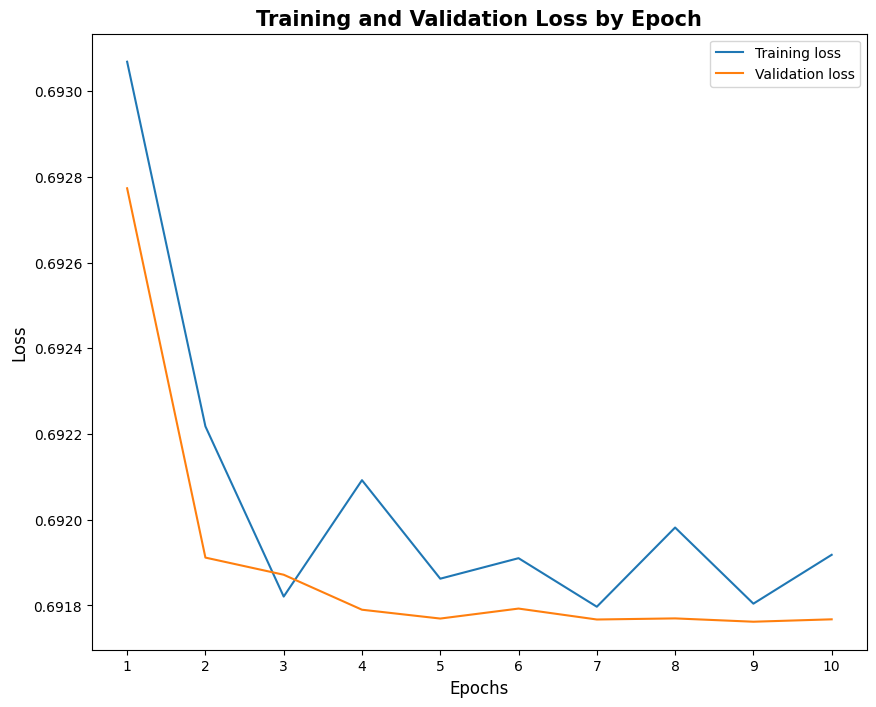

In [104]:
# # Plot the training and validation loss by epoch

plt.figure(figsize=(10,8))
epochs = range(1,11)
plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.xticks(np.arange(1,11,1))
plt.legend();

<img src="../images/loss_by_epoch.png" width="600" align="left">

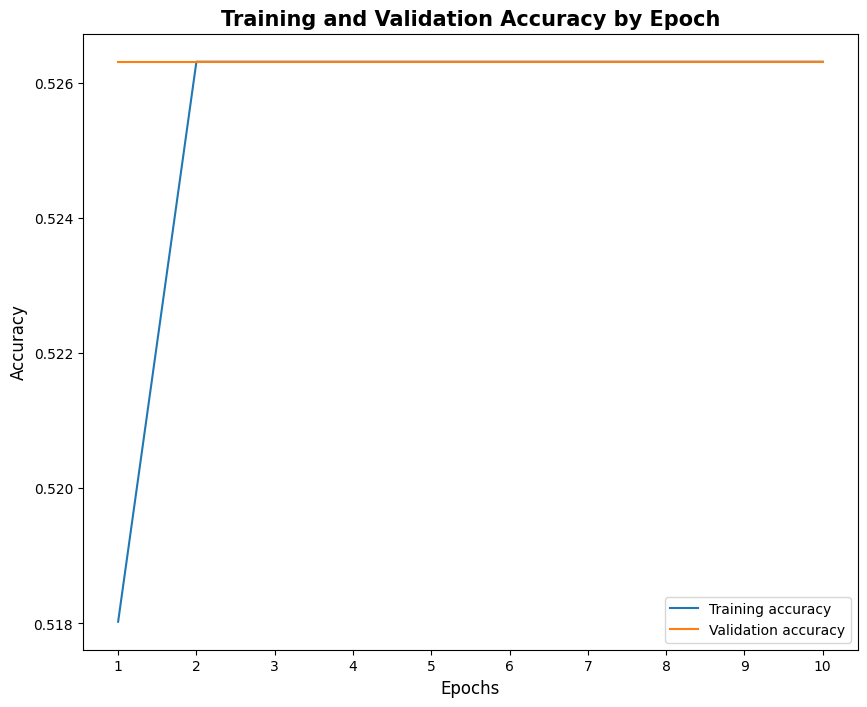

In [105]:
# # Plot the training and validation accuracy by epoch

plt.figure(figsize=(10,8))
epochs = range(1,11)
plt.plot(epochs, history.history['accuracy'], label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')
plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.xticks(np.arange(1,11,1))
plt.legend();

<img src="../images/accuracy_by_epoch.png" width="600" align="left">

Given that validation loss stagnants after the 5th epoch while accuracy peaks at the 5th epoch, we will use the weights from model-05.


### Loading a check-pointed model

<span style="color:red">Change Model Name</span>.

In [107]:
# Load weights
model.load_weights('../output/model2-05-0.53.hdf5')

In [110]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [111]:
# Generate predictions on validation set
class_preds = (model.predict(X_val_padded) > 0.5).astype(int)

19/19 [==============================] - 1s 3ms/step


In [112]:
val_preds = []

# Loop through the class prediction list and append the predictions to val_preds
for i in class_preds:
    val_preds.append(i[0][0])

# Convert val_preds to a series
val_preds = pd.Series(val_preds)

In [113]:
# Accuracy scores
print('Accuracy score on training set: ', model.evaluate(X_train_padded, y_train_list, verbose=0)[1])
print('Accuracy score on validation set: ', model.evaluate(X_val_padded, y_val_list, verbose=0)[1])
print('')

# Print classification report and confusion matrix for validation set
cmat(y_val, val_preds, 'validation set')

Accuracy score on training set:  0.5263158082962036
Accuracy score on validation set:  0.5263158082962036

Classification report for validation set
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       320
           1       0.00      0.00      0.00       288

    accuracy                           0.53       608
   macro avg       0.26      0.50      0.34       608
weighted avg       0.28      0.53      0.36       608


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        320                          0
Actual Negative Review                        288                          0


d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

LSTM did not outperform our BoW model, the Voting Classifier, in accuracy or recall. This may be due to the fact that our dataset is rather small with an average of 7-15 words per review.

## Model Evaluation: Summary Metrics

The table below provides an overview of the models' performance, sorted by accuracy and recall on the validation set in descending order.

|                                                             	| Accuracy on Training Set 	| Accuracy on Validation Set 	| Recall on Validation Set 	|
|:-------------------------------------------------------------	|:--------------------------:	|:----------------------------:	|:--------------------------:	|
| Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.902                    	| 0.904                      	| 0.87                     	|
| TF-IDF & SVC                                                	| 0.901                    	| 0.899                      	| 0.87                     	|
| Count Vectorizer & Naïve Bayes                              	| 0.898                    	| 0.898                      	| 0.83                     	|
| Bidirectional LSTM                                          	| 0.916                    	| 0.896                      	| 0.82                     	|
| TF-IDF & Logistic Regression                                	| 0.906                    	| 0.892                      	| 0.81                     	|
| TF-IDF & Naïve Bayes                                        	| 0.904                    	| 0.882                      	| 0.79                     	|
| Count Vectorizer & SVC                                      	| 0.900                    	| 0.872                      	| 0.75                     	|
| Count Vectorizer & Logistic Regression                      	| 0.882                    	| 0.861                      	| 0.71                     	|

The Voting Classifier was selected as our production model as it achieved the highest accuracy and recall on the validation set. An ensemble of a logistic regression and SVC, the Voting Classifier attained an accuracy of 0.904 on the validation data and a recall of 0.87. Given that the model is able to correctly predict 87% of the actual negative reviews on Google Play, Shopee's product managers will now be able to identify negative reviews and understand the pain points among dissatisfied customers.  

As the base estimators (Logistic Regression and SVC) of our Voting Classifier are rather diverse, the ensemble results in a better accuracy score than the best of the base estimators. The ensemble aggregates the predictions of the base estimators and helps to cover for the weaknesses of the individual models, which in turn reduces the production model's bias.

The model was deployed to [Heroku](https://shopee-sentiment-analysis.herokuapp.com/).

## Production Model's Most Predictive Words

Now, let's look at the most predictive words from the Logistic Regression and SVC to understand how our Voting Classifier classifies positive and negative sentiment.

### Logistic Regression

In [114]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
lr_coef = pd.DataFrame(gs_tvec_lr.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

In [115]:
# Use np.exp() to exponentiate the coefficients
lr_coef['exp_coef'] = np.exp(gs_tvec_lr.best_estimator_.named_steps['lr'].coef_[0])

In [116]:
# Top words related to positive sentiment (class 0)
pos_sent_lr = lr_coef.sort_values(by='exp_coef').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_lr = lr_coef.sort_values(by='exp_coef').tail(10)

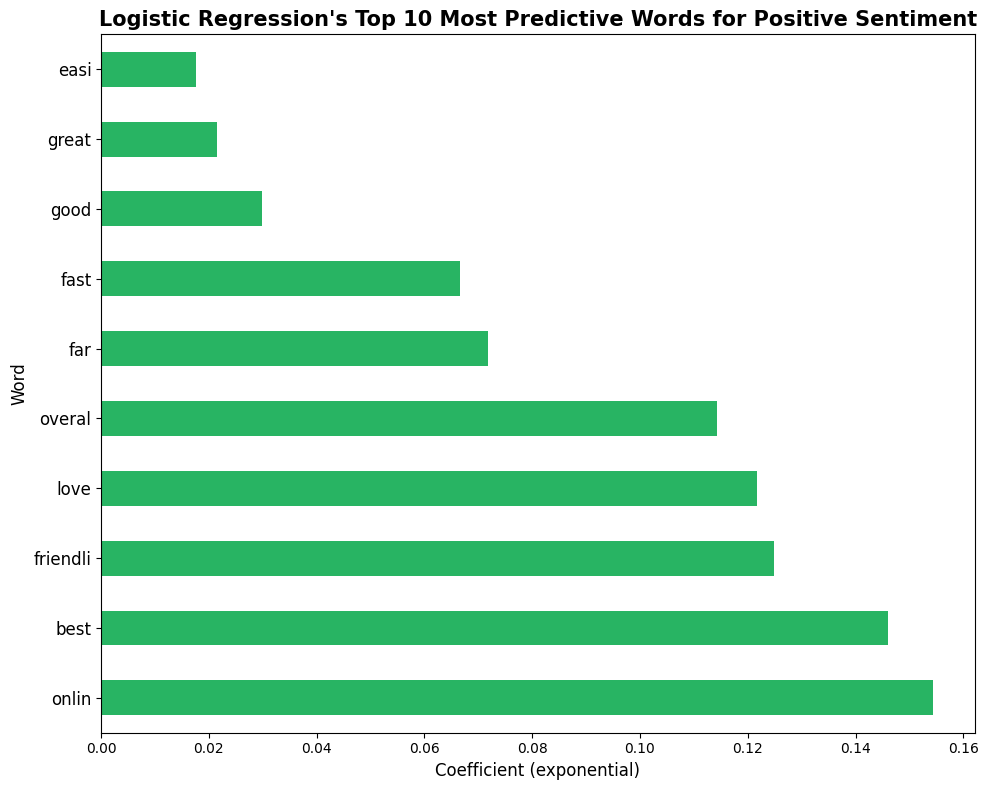

In [117]:
pos_sent_lr.sort_values('exp_coef', ascending=False).plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

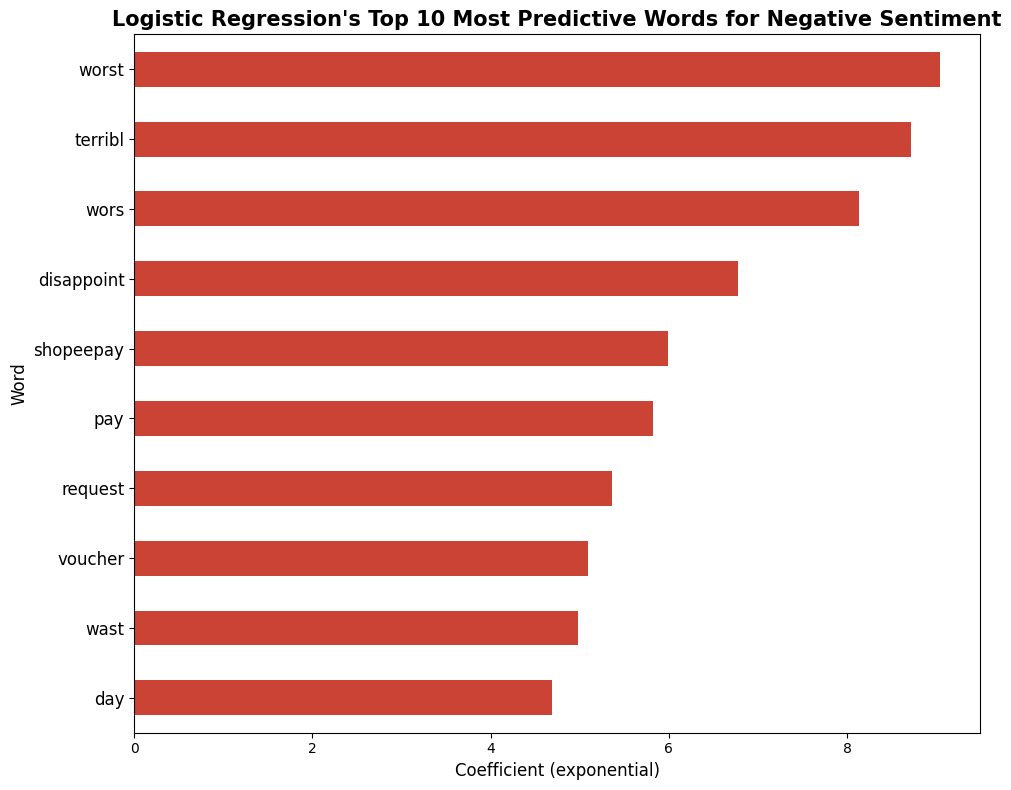

In [118]:
neg_sent_lr.plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

Words like 'easi', 'great', 'good' are the most predictive words associated with positive sentiment. 'Easi' probably refers to Shopee's easy to use shopping platform. On the other hand, 'load', 'worst' and 'scam' are most closely associated to negative sentiment. 'Load' probably relates to the app taking a long time to load while 'scam' may indicate that several customers have encountered seller scams on Shopee. As the occurence of the word 'load' increases by 1, the likelihood of the review being negative, increases by more than 14 times.

### SVC

In [119]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
svc_coef = pd.DataFrame(gs_tvec_svc.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

In [120]:
# Coefficients
svc_coef['coef'] = gs_tvec_svc.best_estimator_.named_steps['svc'].coef_.toarray()[0]

In [121]:
# Top words related to positive sentiment (class 0)
pos_sent_svc = svc_coef.sort_values(by='coef').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_svc = svc_coef.sort_values(by='coef').tail(10)

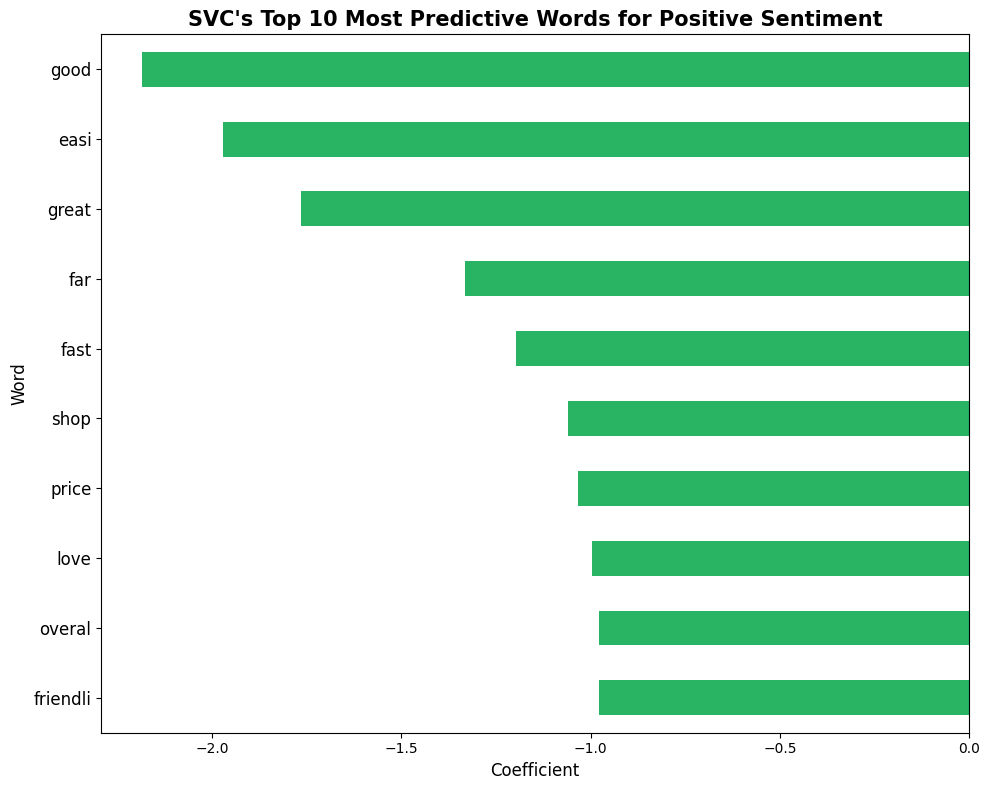

In [122]:
pos_sent_svc.sort_values('coef', ascending=False).plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("SVC's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

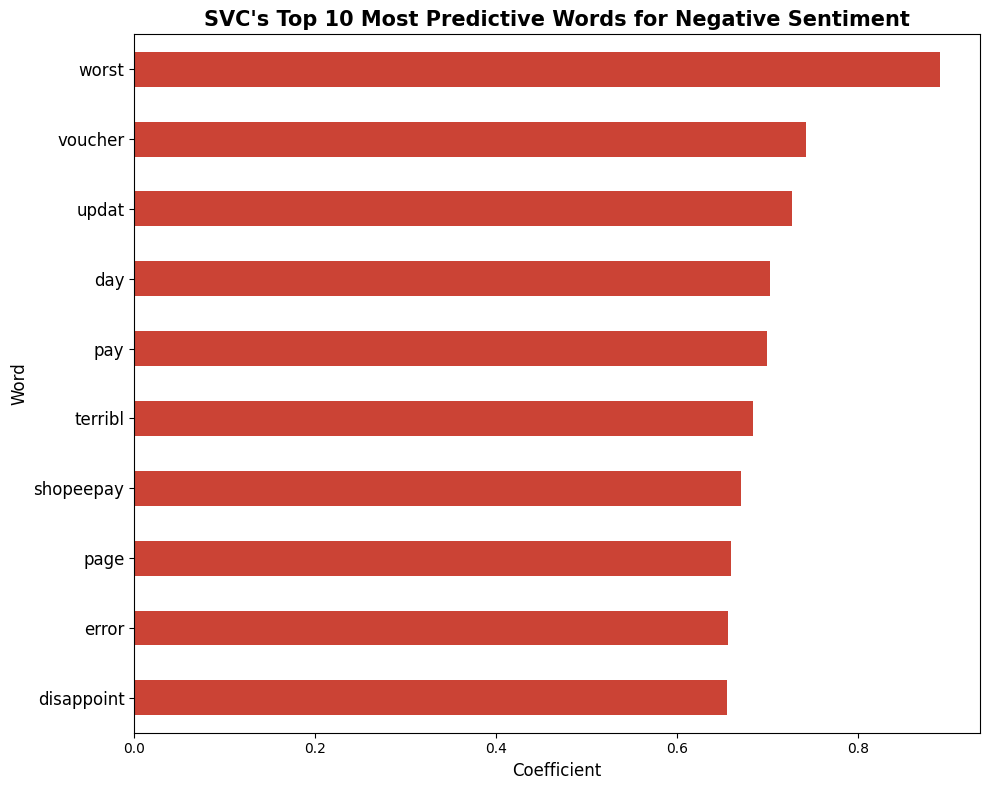

In [123]:
neg_sent_svc.plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("SVC's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

Given that the SVC is non-parametric, we are unable to directly interpret the model's coefficient. Nonetheless, we can tell that there are certain words that are closely related to the positive or negative sentiment in our corpus. Similar to the logistic regression, the SVC indicates that the words 'easi', 'good' and 'great' are related to positive sentiments. On the other hand, words like 'load', 'scam' and 'updat' are closely associated to negative reviews.

## Misclassified Reviews on Validation Set

Let's have a look at the misclassified reviews to understand the limitations in our production model.

In [124]:
# Create a dataframe for only the validation data
val_df = reviews.loc[y_val.index, :] 

# Insert a column for predictions
val_df['pred'] = voting_pred

In [125]:
# Create a column to indicate if the review was correctly predicted
val_df['correctly_classified'] = (val_df['pred'] == val_df['target'])

In [126]:
# 67 misclassified reviews
val_df[val_df['correctly_classified']==0].shape

(97, 6)

In [127]:
# Display the full width so that we can read the misclassified reviews
pd.set_option('display.max_colwidth', None)

# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
val_df[(val_df['target']==0) & (val_df['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
2714,Shoppee is good but the seller some was very bad. Item no stock never inform. Some seller no reply or I cancelled order but the money never returned it back to me!!! they no refund no return whatever all don't have and blame it to shoppee Some seller was best till actually it my first time using shoppee and the sizes I still not very good so I spend some money on item but baby can't wear. The seller never ask me to return the stock and even they resend bigger size for my baby. Good seller,good stock never inform repli cancel order money never return back refund return whatev blame best till actual first time use size still good spend money babi wear never ask return stock even resend bigger size babi good,5,0,1
1812,It's fine at first but after a while some parts of the app just completely breaks down,fine first part complet break,4,0,1
508,Actually app is good but just this few days keep crashing and logged out... tap the app again also same... please fix...,actual good day keep crash log tap also pleas fix,5,0,1
233,Shipping rate is quite standard and clear. Wide range of products. Safe purchase. Encounter defects on purchase where seller refuse to refund the amount i paid for repair. After i raise the dispute with supoorting includes and photos shopee refund to me.,ship rate quit standard clear wide rang product safe purchas encount defect purchas refus refund amount paid repair rais disput supoort includ photo refund,5,0,1
1951,"Having problems such as cannot view the reviews prior to updating my app. Once updated, app is running smooth and easy to switch btwn diff payment methods like top up shopee pay and then payment. Less jam on the coins check in portion too.",problem cannot view review prior updat updat run smooth easi switch btwn diff payment method like top pay payment less jam coin check portion,5,0,1
2989,"The app keep showing 'Server error, please try again' when I want to release payment for parcel received.",keep show server error pleas tri want releas payment parcel receiv,4,0,1
2342,"Very ez to use platform to buy from other resellers or direct suppliers. Being a gold member ever since, so ya. Is either u like it or fcuk it, we also can't please every single mother father son in the world. P.s. please redo on the ads or interest tracking, just show more random stuffs to us instead of our frequent visits on certain products.",ez use platform buy resel direct supplier gold member ever sinc ya either u like fcuk also pleas everi singl mother father son world p pleas redo ad interest track show random stuff us instead frequent visit certain product,4,0,1
402,Some bugs on certain pages e.g. adding to cart sometimes makes the app hang. Otherwise one of the best e-shopping app for SG.,bug certain page e g ad cart sometim make hang otherwis one best e shop sg,4,0,1
2590,Need to spend time gathers the vouchers and offers. You need free time to shop.,need spend time gather voucher offer need free time shop,5,0,1
2442,If only it goes back to the old times where the free coins are more in daily sign in and lesser coins used to redeem voucher then i will award another star.,goe back old time free coin daili sign lesser coin use redeem voucher award anoth star,4,0,1


In [128]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
val_df[(val_df['target']==1) & (val_df['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
2062,"all is great, the product, security features, refund and despute resolution. Except for the coins if buyer rate a purchase which almost always 90% failed to credit as promised despite the video, photo, 50 character comments submitted",great product secur featur refund desput resolut except coin buyer rate purchas almost alway fail credit promis despit video photo charact comment submit,2,1,0
164,"The app is easy to use but a little cluttered Still the search world quite well. The sales and prices are ok. But there is no free shipping now unless you use ShopeePay. In fact, unless you use ShopeePay you won't be saving or getting much deals. I don't like it that they force you to use their payment wallet to enjoy the little discounts. It's not worth it. The other shopping platforms don't tie you down like this.",easi use littl clutter still search world quit well sale price ok free ship unless use shopeepay fact unless use shopeepay save get much deal like forc use payment wallet enjoy littl discount worth shop platform tie like,3,1,0
50,"Decent shopping platform with good deals,but occasionally have logistics hiccups. Tracking often not updated. Customer service seems to be lacking in manpower, but I feel they are working quite hard. The online chat function always disconnect, which is super annoying. advice you to Spend more on your basics functions and less on advertising(especially hiring high profile influential figures) . Sometimes sales price is just the normal retail price, which I think is very unethical.",decent shop platform good deal occasion logist hiccup track often updat custom servic seem lack manpow feel work quit hard onlin chat function alway disconnect super annoy advic spend basic function less advertis especi hire high profil influenti figur sometim sale price normal retail price think uneth,2,1,0
571,Shoppee overcharge me on serveral purchases from my credit card bill can see amount charges is much more than the purchase amount from retails shop prices. Write in to shoppee one month ago till now no news from them. Temporary i stop all my purchases and I do it elsewhere.,overcharg server purchas credit card bill see amount charg much purchas amount retail shop price write one month ago till news temporari stop purchas elsewher,2,1,0
2378,Satisfactory shopping experience. Good platform to compare products. User friendly for item receiving acknowledgement or to put up request for refund however unsure if its reliable. Keep it up ok!!!,satisfactori shop experi good platform compar product user friendli receiv acknowledg put request refund howev unsur reliabl keep ok,3,1,0
1510,Not helpful. Unable to proceed with shopping and payment. Helpdesk not helping,help unabl proceed shop payment helpdesk help,1,1,0
715,"For buying stuff it's great but the games tend to heat up the processor A LOT. You'll need a phone with at least 8Gb RAM to run is app smoothly, any less, and the games will face memory issues.",buy stuff great game tend heat processor lot need phone least gb ram run smoothli less game face memori issu,3,1,0
125,"Some seller not responsive thus had a hard time track my parcel, some item came in wrong colour as order, and a few seller shown clothing as adults but came as kids size, so purchasing is depending on luck. Overall experience is okay. And somehow my particular wasn't protected been received lots of call saying my parcel was been held etc as scam called. Shopee was very lag after a few minutes view. Overall experience was okay. Need more improvements.",respons thu hard time track parcel came wrong colour order shown cloth adult came kid size purchas depend luck overal experi okay somehow particular protect receiv lot call say parcel held etc scam call lag minut view overal experi okay need improv,3,1,0
2999,Cheap prices for the products you're looking for. Definitely some great and terrible experiences. Shopee customer service is definitely inclining. 

Now, that we have looked through the false positives and false negatives. We will identify the top most frequently occuring words to explain the misclassifications.

In [129]:
# Plot a barplot of the top 20 most frequently occuring words in misclassified reviews

def barplot_tvec(df, pred, title, color):
    words_series = df[(df['correctly_classified']==0) & (df['pred']==pred)]['content_stem']
    
    # Instantiate TF-IDF Vectorizer 
    tvec = TfidfVectorizer(stop_words='english')
    
    # Save the tokens in a dataframe
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).todense(), columns=tvec.get_feature_names_out())
    sum_words = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    
    # Chart aesthetics
    plt.title(title, size=15, weight='bold')
    plt.xlabel('Count', size=12)
    plt.xlim(0,5)
    plt.yticks(size=12)
    plt.tight_layout()

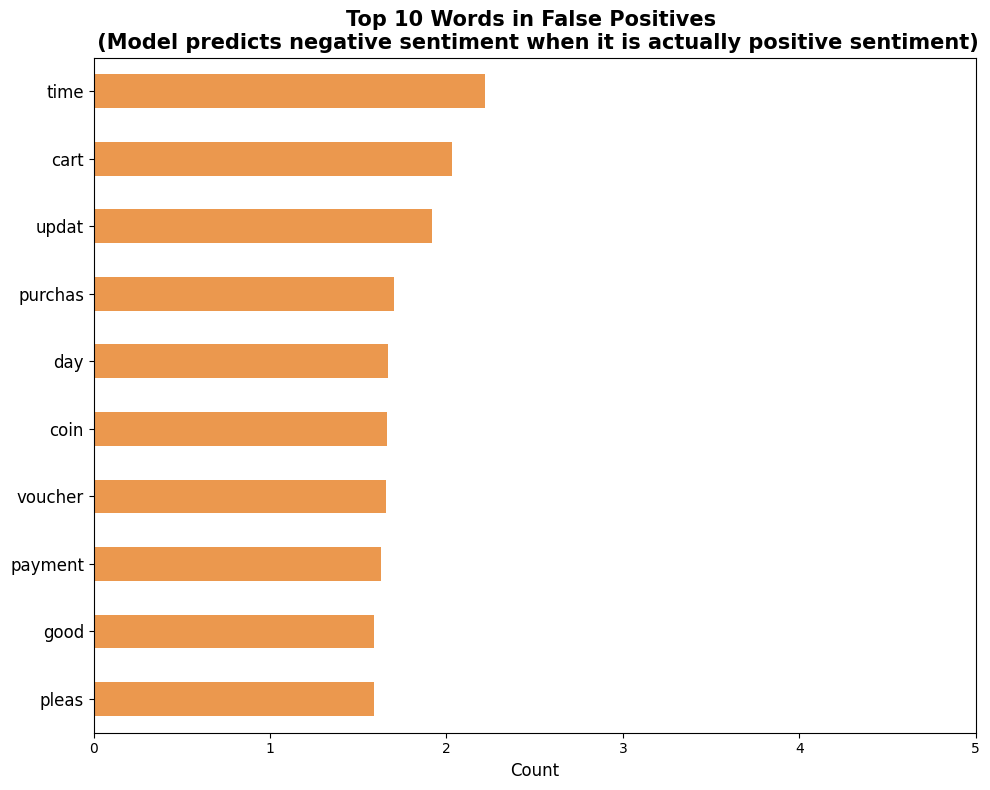

In [130]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=val_df,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#EB984E')

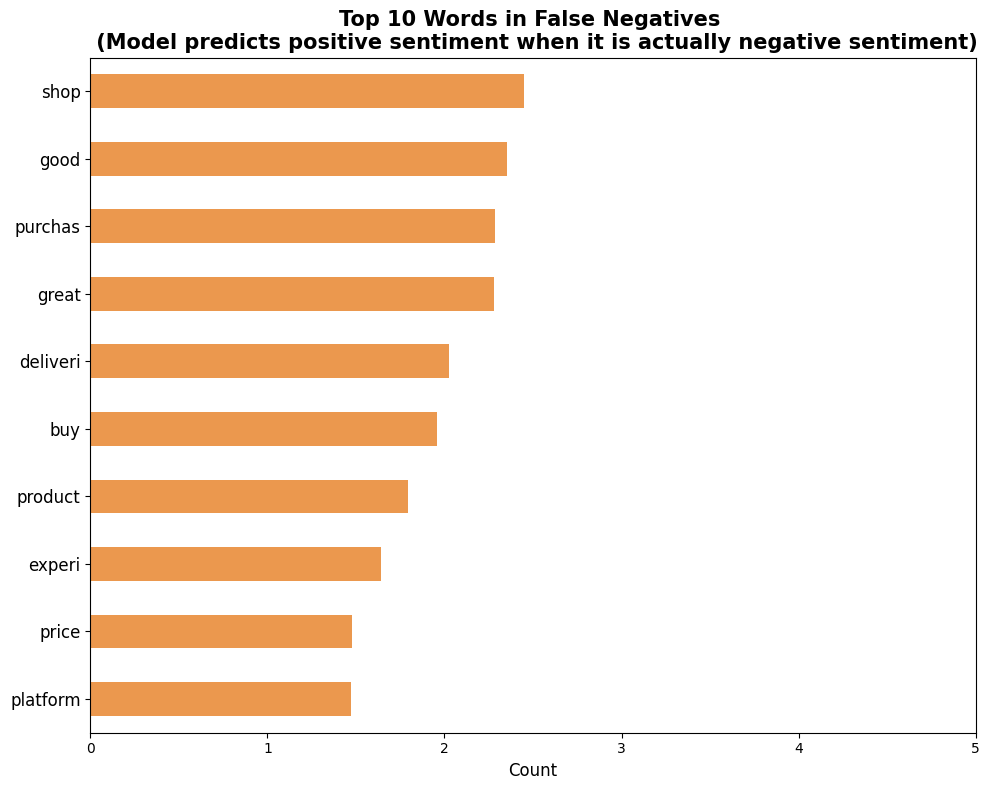

In [131]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=val_df,
             pred=0, 
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)", 
             color='#EB984E')

As observed in the previous section, the word 'good' is a highly predictive word that is closely associated to positive sentiments. Given that the word 'good' appears most frequently in false negatives, the model will incorrectly predict these reviews as having a positive sentiment.

In [132]:
# False Negatives
fn = val_df[(val_df['correctly_classified']==0) & (val_df['pred']==0)][['content','content_stem','score']]

In [133]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

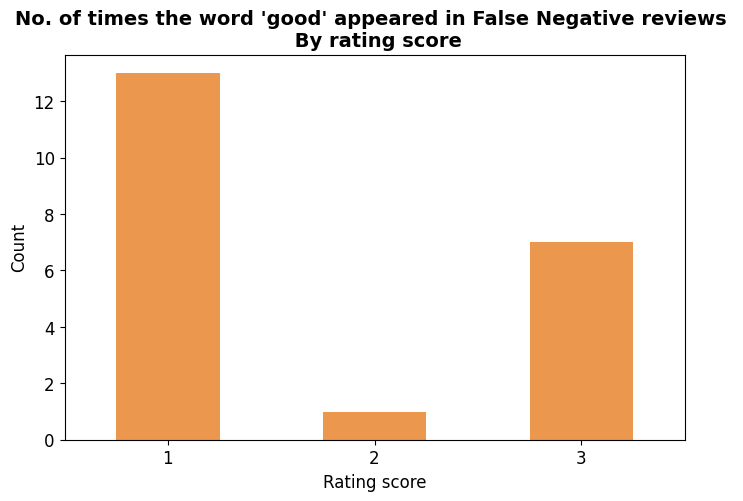

In [134]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

We observe that there are quite a few users who wrote reviews with the word 'good' in them, yet gave the app a rating of 3. Since the model has been trained to believe that the word 'good' belongs to a positive sentiment, the model has thus predicted these to be positive reviews. Hence, misclassifications happen as a result of fence-sitters writing reviews that have positive connotation.

In [135]:
pd.set_option('display.max_colwidth', None)

# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','score']]

,content,score
50,"Decent shopping platform with good deals,but occasionally have logistics hiccups. Tracking often not updated. Customer service seems to be lacking in manpower, but I feel they are working quite hard. The online chat function always disconnect, which is super annoying. advice you to Spend more on your basics functions and less on advertising(especially hiring high profile influential figures) . Sometimes sales price is just the normal retail price, which I think is very unethical.",2
2378,Satisfactory shopping experience. Good platform to compare products. User friendly for item receiving acknowledgement or to put up request for refund however unsure if its reliable. Keep it up ok!!!,3
2874,"Good application for your convenience to buy items that are not available in your local supermarket. The delivery price range is cheaper when compared to Lazada. On the downside, this application, similarly to most ecommerce applications, it caters towards the China market. There were a couple of China products (Which thankfully both I got a refund for) that were dirty and rusty. Please remember that these China products are cheap due to forced labor. Do not support any China product.",3
678,Good app with great shopping experience back then. Now the shipping charges getting more expensive. It was a dollar plus but now it is more than ten dollars. Shopee took away my coins that I had.,1
1285,Review halfway jam and hang there no response like grab app from good to worse app,1
812,This shopee app is was so bad 😞 i buy many stock they send me not good Quality stock even i buy Expensive stuff they give me Stone next time how can i give believe I'm so Sad so decide this app i Not used anymore nobody help me i waste my money,1
837,Experience is soso provided everything went well or product came with good condition. I am always concern about complicated refund issue when shopping on shopee. I had good after sales experience with competitor platform but not on shopee. That is why I dont buy too many or too expensive products on shopee. Refund may be too complicated and a hassel. I remember i 2 years ago i was asked to deal with seller where shopee does not facilitate the process. Thus i was apprehensive.,3
305,The app is good until recently the delivery price is increased and now there is issue in checking my purchased items and also slow when browsing the items.,3
71,Shopping on Shopee is convenient and also good deal. As large and bulky items get delivered to doorstep within a few days.,3
1105,"!!!VERY POOR return policy compared to other online shopping portal, where you raise a concern when a purchased product is not good and want a return/refund for the product then then the seller has an option to raise a dispute where buyer needs to provide too many info which makes it hectic compared to other apps like Lazada, Amazon or Qoo10. Also favours to sellers even if the delivered product quality is bad.",1


## Evaluate Production Model on Test Set

Finally, we will evaluate our model's performance on the test set.

In [136]:
# Read test set into a dataframe
test = pd.read_csv('../data/clean_test2.csv')

In [137]:
# There are 870 documents in our test set
test.shape

(760, 4)

In [138]:
# The class representation in our test set looks similar to our training set as we used stratify
test['target'].value_counts(normalize=True)

0    0.526316
1    0.473684
Name: target, dtype: float64

In [139]:
# Establish our X and y variables
X_test = test['content_stem']
y_test = test['target']

In [140]:
# Generate predictions on test set
test_pred = voting_clf.predict(X_test)

In [141]:
print('Evaluation metrics for test set')
print('')
print('Accuracy score: ', accuracy_score(y_test, test_pred))
print('')

# Print classification report and confusion matrix
cmat(y_test, test_pred, 'test set')

Evaluation metrics for test set

Accuracy score:  0.8447368421052631

Classification report for test set
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       400
           1       0.82      0.86      0.84       360

    accuracy                           0.84       760
   macro avg       0.84      0.85      0.84       760
weighted avg       0.85      0.84      0.84       760


Confusion matrix for test set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        333                         67
Actual Negative Review                         51                        309


Given that our production model achieves 0.892 on accuracy and 0.87 on recall, we can conclude that the model generalises well on unseen data.

### Misclassified Reviews in the Test Set

Let us have a look at the misclassifications in our test set.

In [142]:
# Generate predictions on the test set
test['pred'] = voting_clf.predict(X_test)

In [143]:
# Create a column to indicate if the review was correctly predicted
test['correctly_classified'] = (test['pred'] == test['target'])

In [144]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
test[(test['target']==0) & (test['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
0,"I have a problem with tapping the options. It's like a bug or smthing, that I can't press the options at all and it's indicated that I tapped on the screen just fine, but the options did not appear to be ticked.",problem tap option like bug smthing press option indic tap screen fine option appear tick,5,0,1
4,"Can't go straíght to My Purchase. Hv to click on Get The App (I am already on the app!!). Very silly, really. Each time have to go through the extra step. Pls learn from Lazada.",go stra ght purchas hv click get alreadi silli realli time go extra step pl learn lazada,4,0,1
12,"Terrible. I bought a few items on shoppee and although the product was damaged, i gave 5 stars as the shop offered to refund them but the review was reported as inappropriate so other buyers were not able to see my review. Infuriating. Edited: Improvements in shopee customer service so changed the rating to 4 stars.",terribl bought although product damag gave star shop offer refund review report inappropri buyer abl see review infuri edit improv custom servic chang rate star,4,0,1
17,Love this app. Deducting a star for on this: The current return policy has made it very inconvenient for users to return their products. There is also no option to choose whether you are opting for return or refund. Shipping used to be built into the cost of product. Now its only free if you use Shoppee Pay. The free shipping vouchers are also valid for shoppee pay payment only. Please look into this.,love deduct star current return polici made inconveni user return product also option choos whether opt return refund ship use built cost product free use pay free ship voucher also valid pay payment pleas look,4,0,1
33,I got hooked to the live shows actually. It was nice seeing how live shows actually works while spending little money on things woman loves like accessories and clothes 😄😅 Con: You get addicted 😅🤣 A few remarkable points being their Shopee customer line staffs are pretty responsive and helpful; if lost mail you will still get a refund(?); its an local app so its safer to shop there.,got hook live show actual nice see live show actual work spend littl money thing woman love like accessori cloth con get addict remark point custom line staff pretti respons help lost mail still get refund local safer shop,4,0,1
...,...,...,...,...,...
707,Has multiple promotions and offers almost daily to enjoy more savings. Occasional slowness in loading pages/cart which gave impression app had hung. Need to exit app and relaunch to continue.,multipl promot offer almost daili enjoy save occasion slow load page cart gave impress hung need exit relaunch continu,4,0,1
712,App works as intended. Quite a number of counterfeit goods though. So sieve through and check properly.,work intend quit number counterfeit good though siev check properli,4,0,1
722,I trust Shopee more than other platforms and have been using Shopee a lot this year. Was quite unfortunate twice in a month (disclaimer: my experience on Shopee was mostly positive) - met a scammer seller and didn't get a refund after returning a pair of jeans. Shopee staff was extremely helpful in the investigations and both incidents were resolved quickly!,trust platform use lot year quit unfortun twice month disclaim experi mostli posit met scammer get refund return pair jean staff extrem help investig incid resolv quickli,5,0,1
744,Excellent service & support.,excel servic support,5,0,1


In [145]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
test[(test['target']==1) & (test['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
14,"Welcome free gift isnt even a 'free gift' firstly, the gift is just them getting rid of faulty items. Secondly need to pay for delivery,$1+ for the faulty item. Other than that issue,its not a bad place to shop at.",welcom free gift isnt even free gift firstli gift get rid faulti secondli need pay deliveri faulti issu place shop,3,1,0
18,"Excellent. No problems encountered on all my purchases so far. Edited. But if u are unlucky enough to get ur purchases delivered by WMG, be prepared to cry till no more tears.",excel problem encount purchas far edit u unlucki enough get ur purchas deliv wmg prepar cri till tear,3,1,0
29,"Heaven for Counterfeit goods and admin make no effort in controlling and investigate in those kind of sellers. Basically any people can open an account either scammer or counterfeit sellers, especially those from China. Qoo10 is way better than this platform",heaven counterfeit good admin make effort control investig kind basic peopl open account either scammer counterfeit especi china qoo way better platform,3,1,0
41,"Please be wary of Shopee going forward. The recent promotions have clearly been designed for users to accumulate coin balances with cash, without informing them that the coins expires in a very short period of time. Very distasteful. Trust fundamentally broken here, and I'd imagine lots of consumers will move onto other platforms.",pleas wari go forward recent promot clearli design user accumul coin balanc cash without inform coin expir short period time distast trust fundament broken imagin lot consum move onto platform,1,1,0
48,As a shopping platform its OK. Been using it for years and things were good back then but now all vouchers also need shopee pay. Unless you're telling me its better than my credit card rebates there's really no point. Lazada on the other hand don't have such thing for their discounts. So I'll still be using shopee to shop but shifting more towards your competitor. Spend money on marketing la hire all the big shots la. No use if you don't make customers happy.,shop platform ok use year thing good back voucher also need pay unless tell better credit card rebat realli point lazada hand thing discount still use shop shift toward competitor spend money market la hire big shot la use make custom happi,3,1,0
58,The app is user friendly but the interface keeps resetting to the homepage while browsing which can be quite annoying.,user friendli interfac keep reset homepag brows quit annoy,3,1,0
87,"Shopee customer service only can get refund for buyer. They do not uphold fair trade as per their public notice on their website. Paid lower price for an item, seller can indicate it as delivered even when lost in transit. Then seller will offer you to buy at a higher price because the discounted price has expired, for a higher revenue at the buyer's cost.",custom servic get refund buyer uphold fair trade per public notic websit paid lower price indic deliv even lost transit offer buy higher price discount price expir higher revenu buyer cost,2,1,0
146,Good for online shopping. The only downside is that the app can be very buggy and unresponsive. It doesnt load properly at times and it's making me not want to use it.,good onlin shop downsid buggi unrespons doesnt load properli time make want use,2,1,0
150,"Well shopee is now forcing to use shopee pay for discount and i'm not very happy with that. And without the discount voucher, the prices are not any more interesting.",well forc use pay discount happi without discount voucher price interest,3,1,0
158,Shopee is my most favourite eCommerce platform. But recently I have some bad experiences. Cost for Standard Economy has increased to $0.60. Collection points have been spread out further and further. There are so many Pick Lockers around but the nearest one Shopee is using is 6 bus stops away from my flat. Why?,favourit ecommerc platform recent experi cost standard economi increas collect poin

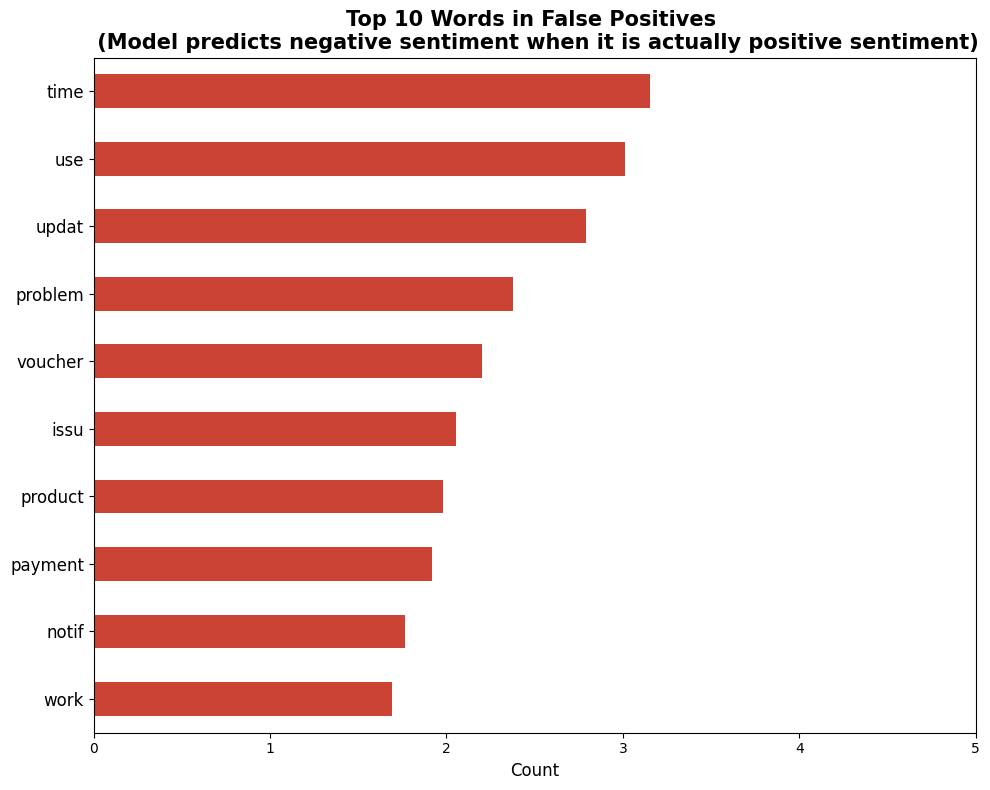

In [146]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=test,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#CB4335')

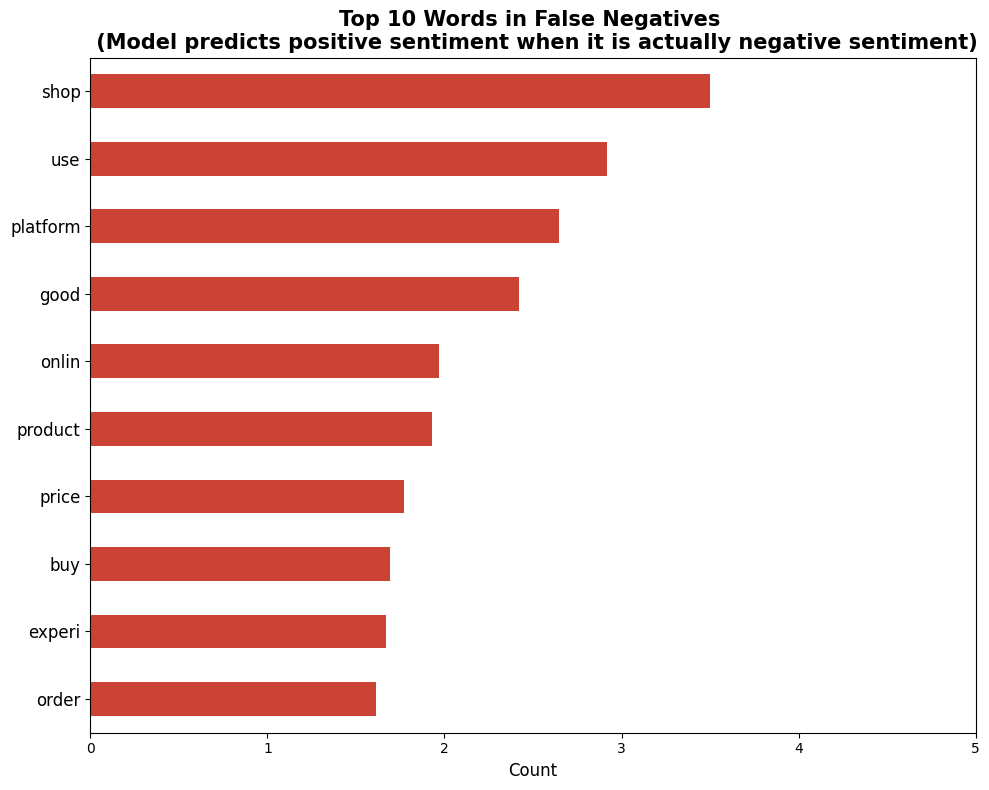

In [147]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=test,
             pred=0, 
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)", 
             color='#CB4335')

In [148]:
# False Negatives
fn = test[(test['correctly_classified']==0) & (test['pred']==0)][['content','content_stem','score']]

In [149]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

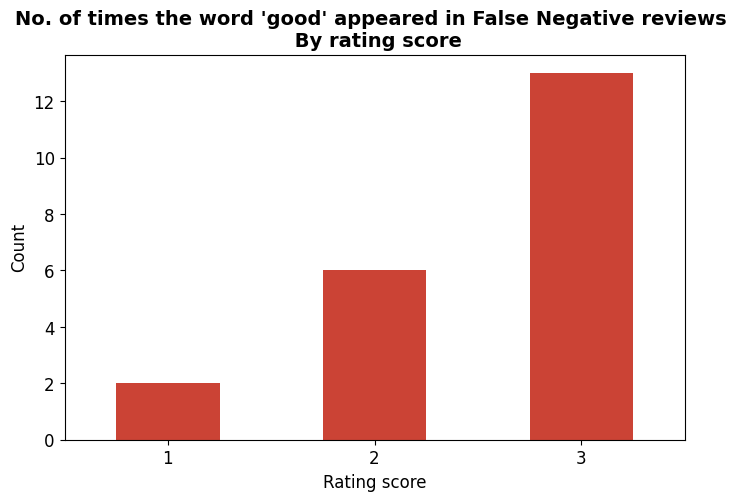

In [150]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#CB4335')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

In [151]:
# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','content_stem','score']].sort_values(by='score')

,content,content_stem,score
322,my first time trying to buy things on Shopee. the app is good but I can't say the same for the sellers I'm dealing with. Both times I have bad experience with 2 different sellers. First product came broken and the second one didn't ship out my item after a week despite telling me they'll ship out several times. It's the kind of quality of the sellers/products for cheap prices. Just beware!,first time tri buy thing good say deal time experi differ first product came broken second one ship week despit tell ship sever time kind qualiti product cheap price bewar,1
260,"The issue of this rated 🌟 with genuine consideration is that whenever we have to scroll down to the desired item that we're planning on purchasing, it always automatically resets/reverts back to the top of the pile in the Shopping cart Which is a Hassel having to manually scroll down back to the desired item that we're planning on purchasing... Although it does good for our fingers exercising :)",issu rate genuin consider whenev scroll desir plan purchas alway automat reset revert back top pile shop cart hassel manual scroll back desir plan purchas although good finger exercis,1
146,Good for online shopping. The only downside is that the app can be very buggy and unresponsive. It doesnt load properly at times and it's making me not want to use it.,good onlin shop downsid buggi unrespons doesnt load properli time make want use,2
502,"The software itself is good but help center is not good enough. If sellers sent wrong item to you and you ask for refund, Shopee will tell that item is correct and rejected your request. DO NOT RECOMMEND BUYING ON THIS PLATFORM",softwar good help center good enough sent wrong ask refund tell correct reject request recommend buy platform,2
211,"I had a good impression that this is a good shopping platform until I ran into a dispute when I was requesting a refund prior to receiving the product. What on earth a product took 2 weeks to be delivered. Please don't give the old school excuse ""we have high shipping volume during peak hour"" as a 6 years old know 11.11/12.12 are peak periods so please manage your manpower.",good impress good shop platform ran disput request refund prior receiv product earth product took week deliv pleas give old school excus high ship volum peak hour year old know peak period pleas manag manpow,2
581,"The app interface is not intuitive enough, leading to mistakes and confusing, but frankly speaking its better than Q10 etc. The shopee official store and service is not good, wrong delivery for my first order, and refund took very long. Other individual stores still ok, but shoppee still have big room for improvements.",interfac intuit enough lead mistak confus frankli speak better q etc offici store servic good wrong deliveri first order refund took long individu store still ok still big room improv,2
568,I hope all seller send out items to be fast. N items be in good conditions. Overall OK accept for the waiting duration.,hope send fast n good condit overal ok accept wait durat,3
541,The app is so so. Not happy with the delivery service. Delivery man always dun bother to press the door bell to see whether people at home to receive the order but simply left the goods outside the house.,happi deliveri servic deliveri man alway dun bother press door bell see whether peopl home receiv order simpli left good outsid hous,3
476,"Nowadays spending more time on your games to earn coins instead of actual shopping. Good vouchers are always fully redeemed within few minutes. Sometimes price on Ezbuy are cheaper than shopee without the need of standing by to snatch vouchers. Just sharing my thoughts, will still continue buying from Shopee anyway.",nowaday spend time game earn coin instead actual shop good voucher alway fulli redeem within minut sometim price ezbuy cheaper without need stand snatch voucher share thought still continu buy anyway,3
430,Edited: Easy to use for purchases. Good selec

Misclassification in the context of 'good' occurs when:
- User leaves a positive review but gives rates the app 3-stars. For example, "good app with reasonable price". These kinds of misclassifications are unavoidable and even a human will interpret it to be positive sentiment.
- User writes a review that mentions Shopee is 'good' in a one aspect, but indicates that there are other areas of improvement. Misclassifications of this sort can be reduced if the model was trained on more negative sentiment. Given the limited pool of negative reviews on Google Play, we can look into training the model on negative reviews from the Apple App Store in the future. 
- Given that we have removed stopwords like 'not' and 'no' during pre-processing, the word 'good' rather than 'not good' will be fed into the model. As these reviews typically contain very few words and do not provide feedback on how Shopee can improve the app experience, there are no dire consequences to such misclassifications.

## Topic Modeling for Negative Sentiment

Next, we will use Gensim's LDA to identify the key pain points that dissatisfied customers are facing. 

Before running LDA, we will first perform a simple pre-processing by removing stopwords, lemmatizing and using SpaCy to only keep tokens that are nouns, adjectives, verbs or adverbs. This approach gave us more distinct topics than if we were to just rely on the same pre-processing approach as that used during classification modeling.

In [152]:
# Create a list of all the textual data from negative reviews
data = reviews[reviews['target']==1]['content'].values.tolist()

In [153]:
# Assign NLTK's stopwords to stop_words
stop_words = stopwords.words('english')

# Include frequently occuring words like 'app' and 'shopee' to the stopwords list. These words will not value add to our topics.
stop_words.extend(['app','shopee','shoppee','shoppe'])

In [154]:
# !python -m spacy download en_core_web_sm

In [155]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) 
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# Pre-processing text
data_ready = process_words(data)

In [156]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready) 

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # Number of topics
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.016*"update" + 0.015*"keep" + 0.014*"try" + 0.014*"issue" + 0.013*"game" '
  '+ 0.013*"work" + 0.012*"use" + 0.012*"even" + 0.012*"go" + 0.011*"still"'),
 (1,
  '0.038*"use" + 0.028*"voucher" + 0.022*"purchase" + 0.020*"pay" + '
  '0.017*"product" + 0.016*"well" + 0.015*"coin" + 0.014*"payment" + '
  '0.014*"shipping" + 0.013*"make"'),
 (2,
  '0.030*"seller" + 0.026*"item" + 0.025*"refund" + 0.024*"customer" + '
  '0.023*"order" + 0.021*"service" + 0.019*"bad" + 0.015*"delivery" + '
  '0.012*"even" + 0.012*"receive"')]


In [157]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formatting the table
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

C:\Users\steam\AppData\Local\Temp\ipykernel_24020\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppData\Local\Temp\ipykernel_24020\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppData\Local\Temp\ipykernel_24020\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppD

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.9282,"seller, item, refund, customer, order, service, bad, delivery, even, receive","[face, really, bad, experience, warehouse, show, return, item, tracking, number, give, item, still, warehouse, fake, tracking, post, track, invalid, show, item, deliver, also, say, take, working, day, return, item, order, item, get, deliver, day, bad, experience, wish, give, star, kind, experience]"
1,1,2,0.7068,"seller, item, refund, customer, order, service, bad, delivery, even, receive","[finally, refunded, item, return, declare, miss, courier, improve, return, refund, system, safeguard, customer, enough, provide, clear, step, step, instruction, customer, return, process, also, review, language, use, confuse, eg, deliver, pick, different, meaning]"
2,2,0,0.6322,"update, keep, try, issue, game, work, use, even, go, still","[select, multiple, message, delete, habit, clear, unnecessary, message, system, generate, message, water, person, plant, lol, choice, delete, multiple, message, touch, definitely, make, well, user, experience]"
3,3,0,0.9572,"update, keep, try, issue, game, work, use, even, go, still","[wrong, last, update, top, bar, screen, go, way, top, touch, chat, setting, button, phone, setting, open]"
4,4,0,0.6286,"update, keep, try, issue, game, work, use, even, go, still","[slow, peak, time, screen, product, list, game, load, time, example, shake, screen, farm, team, need, ensure, people, use, product, properly]"


In [158]:
# Keywords of each dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show the 3 topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9704,"update, keep, try, issue, game, work, use, even, go, still","[buggy, crash, load, sometimes, constantly, run, background, also, constantly, drain, phone, battery, cause, phone, heat, uninstall, reinstall, multiple, time, get, somewhat, work]"
1,1,0.9799,"use, voucher, purchase, pay, product, well, coin, payment, shipping, make","[new, user, get, voucher, gift, card, voucher, together, new, user, gift, know, use, voucher, use, dollar, first, expire, early, purchase, become, invalid, unreasonable, tell, vocher, new, user, make, specific, use, disappointing, even, get, gift, card]"
2,2,0.9828,"seller, item, refund, customer, order, service, bad, delivery, even, receive","[suck, service, product, buy, time, always, disappoint, delivery, time, product, quality, last, time, give, chance, seller, local, bad, item, deliver, change, status, deliver, feedback, customer, service, machine, keep, ask, check, item, alot, box, small, ask, proof, delivery, never, address, request, piss]"


d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will b

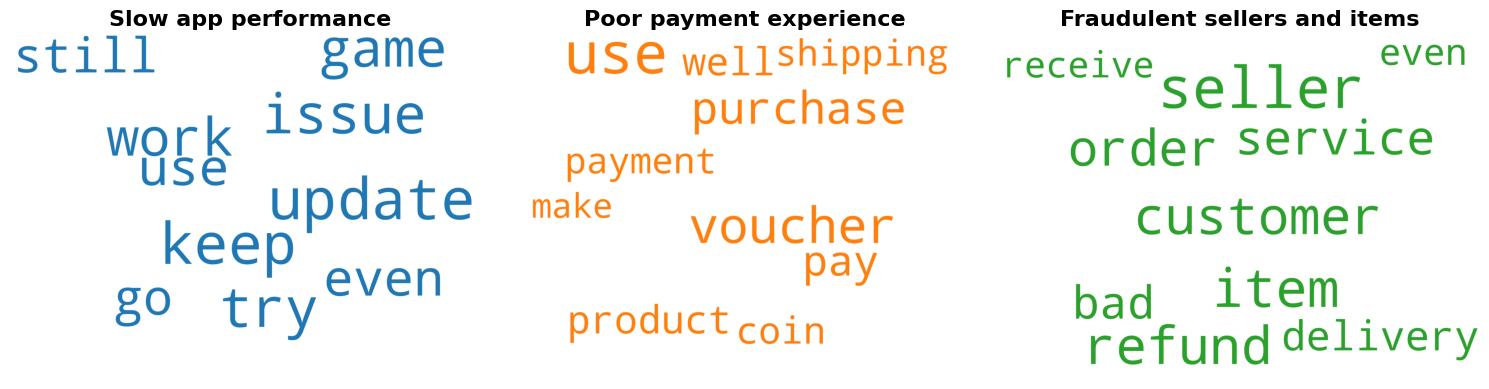

In [159]:
# Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True, sharey=True)

topic_names = ['Slow app performance', 'Poor payment experience', 'Fraudulent sellers and items']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [160]:
# Visualisation of the topics estimated using LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.043508 -0.232338       1        1  37.968215
0     -0.187995  0.152314       2        1  35.926942
1      0.231504  0.080023       3        1  26.104843, topic_info=         Term        Freq       Total Category  logprob  loglift
304    seller  388.000000  388.000000  Default  30.0000  30.0000
50        use  478.000000  478.000000  Default  29.0000  29.0000
198   voucher  243.000000  243.000000  Default  28.0000  28.0000
44     refund  317.000000  317.000000  Default  27.0000  27.0000
30   customer  312.000000  312.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
200       buy   72.134641  139.041614   Topic3  -4.7993   0.6868
8        give   74.105621  168.287095   Topic3  -4.7724   0.5229
7         get   92.004690  354.399957   Topic3  -4.5560  -0.0055
909    option   51.551747   84.106460   Topic3  -5.1353   0.8536
10       item   53.644235  438.301053   Topic3  -5.0955  -0.7575

[164 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
113       2  0.987404  account
450       2  0.874894      add
450       3  0.115795      add
288       1  0.994761    agent
355       1  0.997577      ask
...     ...       ...      ...
198       3  0.997210  voucher
224       1  0.994664     wait
67        2  0.006956     well
67        3  0.994765     well
338       2  0.996223     work

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

We can conclude that the 3 topics are rather distinct as the bubbles are far away from one another on the intertopic distance map. The bar chart on the right represents the individual terms that are the most useful for interpreting a selected topic.   

We will be browsing through some of the negative reviews in our dataset to better contextualise the 3 pain points that the LDA model has identified.

In [163]:
# Browse through the reviews that contain the top words related to each topic
reviews[(reviews['target']==1) & (reviews['content'].str.contains('seller'))]['content']

49             All is well until something went wrong. 1 item was delivered damaged and shippment took around 3 wks, seller was responsive n immediately arranged replacement shippment, taking 2 wks. But shoppee system cannot extend the guarantee period n the service agent advice to either trigger the refund or wait for the shippment. Strange that buyer had to take such a risk. 2nd shippment arrived damaged n offline refund need to be requested. And there are additional requirements no mentioned earlier.
56                                                          The CS team really cannot make it. Ask why my ordered stuff not ship they told me order will be auto cancel if seller don't ship ment a certain date. For what I would want to place an order and later cancel it? Asked their help to seek clarification they said 3 to 5 working days and before they can reply order cancelled. Really upset and was still anticipate my item to come. Now my voucher burn, who is going to compensate anoth

## Pain Points and Recommendations

**Poor payment experience** 

Customers are most frustrated when they run into payment issues during checkout. The payment was either denied or the payment page simply took too long to load. Although customers are given the option of paying via bank transfers, the process is not entirely seamless. Some were not able to upload the receipt for verification due to a platform error. A handful of customers have also mentioned in their Google Play reviews that they were not able to apply their voucher or discount codes at the point of checkout. We can imagine the disappointment that customers face when they were not able to enjoy the promotional prices that were promised.

Consumers today demand a fast, convenient and secure payment experience. As such, the software engineers at Shopee will need to look into enhancing the stability and reliability of its payment gateway service. Given that card payments are processed through third-party providers, engineers will need to figure out if these payment issues are surfacing from the third-party providers' end, or as a result of Shopee's internal systems. Reducing friction in the payment process will definitely help to reduce cart abandonment.

**Fraudulent sellers and items**  

Several customers have reported fraudulent seller behaviour. These scams include not having received the items ordered, or receiving counterfeit, defective products. When these issues were raised to Shopee's customer service, the problem was either not resolved in a timely fashion, or customers did not receive their refunds. This has thus disappointed and angered many affected customers and several feel that Shopee favours the sellers over the buyers.   

Building a robust model that identifies and blocks fraudulent sellers at the early stages will help to prevent seller fraud and preserve buyers' trust. This involves tracking a range of behavioural pattern among sellers and combing through their digital identity for any signs of suspicious behaviour. While the team continues to build better fraud detection algorithms, it will not be possible to completely stamp out frauds. Shopee could improve its buyers' protection scheme to boost buyers' confidence. Given Shopee's escrow service, in the event when the order is not delivered or the items do not match the seller's description, Shopee should reimburse the full cost to the customer.

**Slow app performance**

Users have reported that the app hangs or crashes at the login and payment page. This is an issue of latency, meaning that there is a delay between an action and a response. Several other reviews have also mentioned that the app's functionalities had slowed down considerably after updating the app. Some were reportedly not able to load Shopee's games after updating the app, and were thus upset that they could not collect Shopee coins. These coins can be used to offset the cost of the next purchase.

Developers will need to optimise Shopee's traffic scheduling platform's throughput and latency. Ensuring smooth running of the platform is crucial especially during big sale events where the server runs the risk of being overloaded due to high traffic. Developers will also need to stress test before releasing new app updates to ensure that the app's performance is not compromised.

## Conclusion

The production model is a Voting Classifier consisting of an ensemble of a Logistic Regression and SVC. Given its relatively high accuracy (0.892) and recall (0.87) on the test set, we can conclude that the model generalises well on unseen data. This model serves as a good start for Shopee's product managers to classify sentiments and understand customers' pain points through Google Play reviews.

The data science team has also identified 3 pain points among dissatisfied customers through topic modeling. Product managers will need to work closely with software engineers and developers to build a seamless payments experience, crack down on fraudulent sellers and improve app performance in terms of latency.
 
Despite the model's relatively high performance, there is still room for improvement. Misclassifications tend to occur when users leave mixed reviews on Shopee. For instance, when the user praises Shopee for being 'good' in one aspect, but indicates that there are other areas of improvement, the model classifies this is a positive review. Sentiments are inherently subjective. However, given that the user is dissatisfied with certain aspects of the shopping experience, it is worth classifying such reviews as negative sentiments. This will allow product managers to be informed of these pain points. In order to reduce misclassifications, we can train the model on reviews from the Apple App Store too. Given that we have also identified customers' pain points, the next step would be to use these topics as features in our sentiment classification model. This may help to improve the model's accuracy and recall.